# Segmentation Training: U-Net for Lesion Segmentation

**Goals:**
- Train U-Net (ResNet-34 encoder) with 5-fold CV
- Optimize Dice+BCE loss
- Track metrics: Dice, IoU, Boundary F1
- Save best checkpoints per fold
- Aggregate results and report mean ± std

In [1]:
# Imports
import sys
sys.path.append('..')

import torch
import lightning as L
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import seed_everything
from src.datamodules.bus_uc import BusUcSegDataModule
from src.models.seg_unet import UNetRes34, LightningSegModel
from src.losses import DiceBCELoss
from src.metrics import dice_score, iou_score

/Users/theomoura/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Configuration

In [2]:
# Load config from ../configs/seg_unet.yaml
config = yaml.safe_load(open('../configs/seg_unet.yaml'))
print("Configuration loaded:")
for key, val in config.items():
    print(f"  {key}: {val}")

Configuration loaded:
  task: segmentation
  model: unet_res34
  data_dir: BUS_UC/BUS_UC/BUS_UC
  img_size: 256
  in_channels: 3
  encoder_name: resnet34
  encoder_weights: imagenet
  num_classes: 1
  optimizer: adamw
  lr: 0.001
  weight_decay: 0.0001
  scheduler: cosine
  epochs: 100
  early_stop_patience: 10
  batch_size: 16
  num_workers: 4
  loss: {'name': 'dice_bce', 'dice_weight': 0.5, 'bce_weight': 0.5}
  augment: medium
  kfolds: 3
  seed: 42
  metrics: ['dice', 'iou', 'boundary_f1']
  mixed_precision: True
  gradient_clip: 1.0
  save_best_by: dice
  use_swa: False
  swa_start_epoch: 95


## 2. Data Preparation

Train samples: 648
Val samples: 163
Test samples: 163


/Users/theomoura/Documents/coding/university/xai/bus-uc-breast-ultrasound/notebooks/../src/transforms/ultrasound.py:32: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=10, sigma=4, alpha_affine=0, p=elastic_p),
/Users/theomoura/.pyenv/versions/3.11.9/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


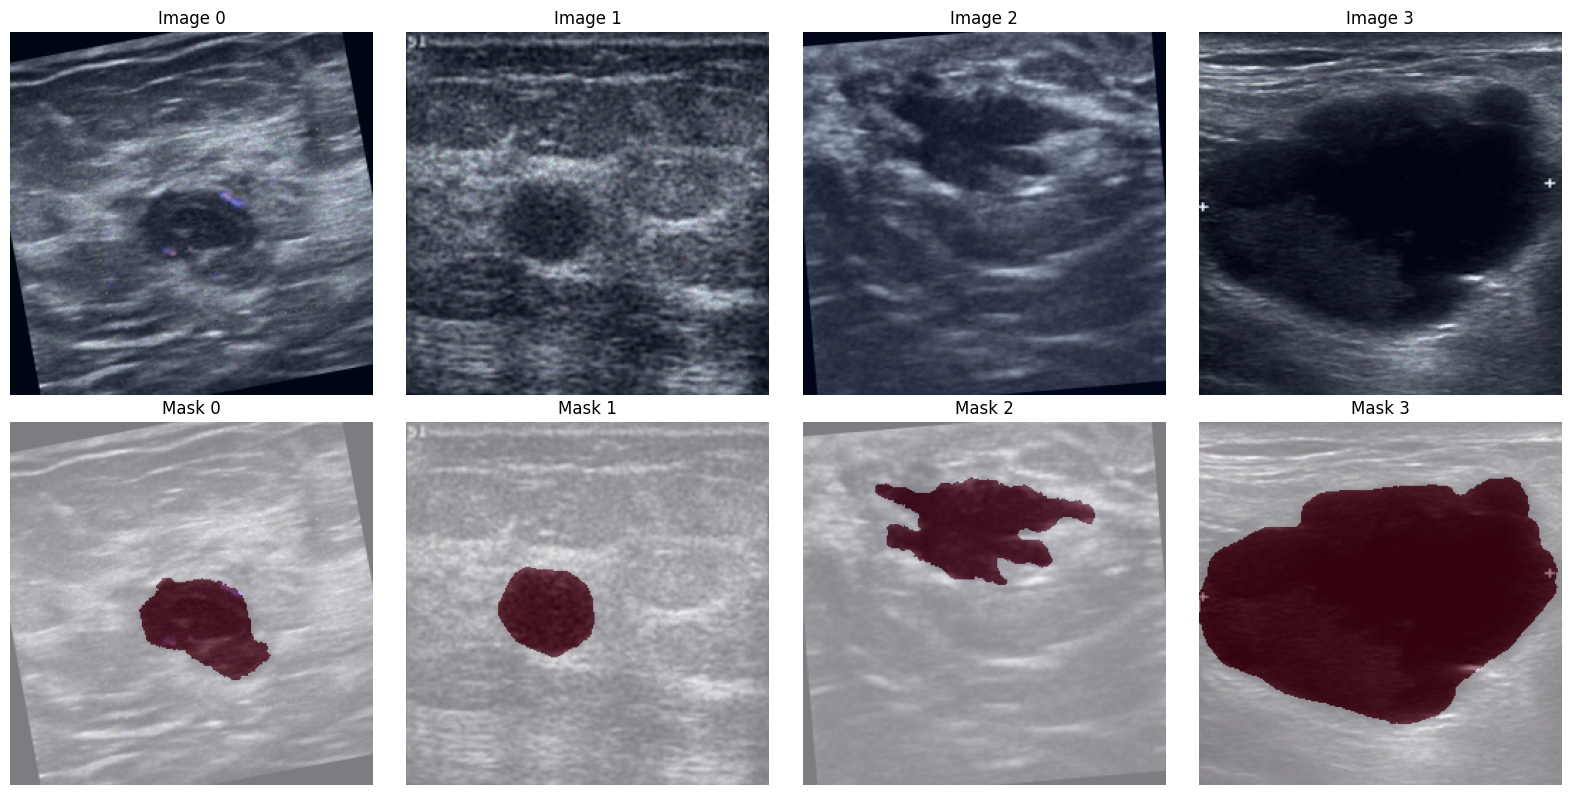

✓ Data visualization complete


In [3]:
# Initialize DataModule for fold 0
seed_everything(42)

datamodule = BusUcSegDataModule(
    data_dir=config['data_dir'],
    img_size=config['img_size'],
    batch_size=config['batch_size'],
    augment_level=config['augment'],
    fold=0,
    n_folds=config['kfolds'],
    seed=config['seed']
)
datamodule.setup()

print(f"Train samples: {len(datamodule.train_dataset)}")
print(f"Val samples: {len(datamodule.val_dataset)}")
print(f"Test samples: {len(datamodule.test_dataset)}")

# Visualize batch
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
images, masks = batch['image'], batch['mask']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    # Original image
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Image {i}")
    axes[0, i].axis('off')
    
    # Mask overlay
    mask = masks[i, 0].cpu().numpy()
    axes[1, i].imshow(img)
    axes[1, i].imshow(mask, alpha=0.5, cmap='Reds')
    axes[1, i].set_title(f"Mask {i}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("✓ Data visualization complete")

## 3. Model Initialization

In [4]:
# Initialize U-Net model
backbone = UNetRes34(
    num_classes=1,
    encoder_name='resnet34',
    encoder_weights='imagenet'
)

loss_fn = DiceBCELoss(
    dice_weight=config['loss'].get('dice_weight', 0.5),
    bce_weight=config['loss'].get('bce_weight', 0.5)
)

lightning_model = LightningSegModel(
    model=backbone,
    loss_fn=loss_fn,
    learning_rate=config['lr'],
    weight_decay=config['weight_decay'],
    scheduler=config['scheduler'],
    epochs=config['epochs']
)

# Print model summary
print(f"Model: {config['model']}")
print(f"Loss: {config['loss']['name']}")
print(f"Learning rate: {config['lr']}")
print(f"Epochs: {config['epochs']}")
print(f"Batch size: {config['batch_size']}")

# Count parameters
total_params = sum(p.numel() for p in backbone.parameters())
trainable_params = sum(p.numel() for p in backbone.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model: unet_res34
Loss: dice_bce
Learning rate: 0.001
Epochs: 100
Batch size: 16

Total parameters: 24,436,369
Trainable parameters: 24,436,369


## 4. Training (Single Fold)

In [5]:
# Set up Trainer with callbacks
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath='../outputs/seg_unet_fold0',
    filename='best',
    monitor='val_dice',
    mode='max',
    save_top_k=1
)

early_stop_callback = EarlyStopping(
    monitor='val_dice',
    patience=config['early_stop_patience'],
    mode='max'
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
logger = CSVLogger(save_dir='../outputs', name='seg_unet_fold0')

# Train
trainer = L.Trainer(
    max_epochs=config['epochs'],
    accelerator='auto',
    devices=1,
    precision='16-mixed' if config['mixed_precision'] else 32,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    logger=logger,
    gradient_clip_val=1.0,
    deterministic=True
)

print("Starting training...")
trainer.fit(lightning_model, datamodule=datamodule)
print("✓ Training complete")

Using 16bit Automatic Mixed Precision (AMP)
/Users/theomoura/.pyenv/versions/3.11.9/lib/python3.11/site-packages/lightning/pytorch/plugins/precision/amp.py:53: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/theomoura/.pyenv/versions/3.11.9/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/theomoura/Documents/coding/university/xai/bus-uc-breast-ultrasound/outputs/seg_unet_fold0 exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | UNetRes34   | 24.4 M | train
1 | loss_fn | DiceBCELoss | 0      | train
------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)
191       Modules in trai

Starting training...
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/theomoura/.pyenv/versions/3.11.9/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


/Users/theomoura/.pyenv/versions/3.11.9/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9:  88%|████████▊ | 36/41 [00:22<00:03,  1.60it/s, v_num=0, val_loss=0.110, val_dice=0.903, train_loss=0.0967, train_dice=0.914]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## 5. Evaluation

In [ ]:
# Load best checkpoint and evaluate on test set
test_results = trainer.test(ckpt_path='best', datamodule=datamodule)
print("\nTest Results:")
for key, val in test_results[0].items():
    print(f"  {key}: {val:.4f}")

# Visualize predictions
test_loader = datamodule.test_dataloader()
batch = next(iter(test_loader))

lightning_model.eval()
with torch.no_grad():
    images = batch['image']
    masks_gt = batch['mask']
    masks_pred = torch.sigmoid(lightning_model(images))

# Plot examples
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    
    mask_gt = masks_gt[i, 0].cpu().numpy()
    mask_pred = (masks_pred[i, 0].cpu().numpy() > 0.5).astype(float)
    
    # Image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Input')
    axes[i, 0].axis('off')
    
    # GT mask
    axes[i, 1].imshow(mask_gt, cmap='Reds')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    # Predicted mask
    axes[i, 2].imshow(mask_pred, cmap='Reds')
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    # Overlay
    axes[i, 3].imshow(img)
    axes[i, 3].imshow(mask_pred, alpha=0.5, cmap='Reds')
    axes[i, 3].set_title('Overlay')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

print("✓ Evaluation complete")

## 6. Cross-Validation (All Folds)

In [ ]:
# Run training for all 5 folds
import json
import numpy as np

results = []
for fold in range(config['kfolds']):
    print(f"\n{'='*60}")
    print(f"Training Fold {fold}/{config['kfolds']}")
    print(f"{'='*60}")
    
    # Seed
    seed_everything(config['seed'] + fold)
    
    # DataModule
    dm = BusUcSegDataModule(
        data_dir=config['data_dir'],
        img_size=config['img_size'],
        batch_size=config['batch_size'],
        augment_level=config['augment'],
        fold=fold,
        n_folds=config['kfolds'],
        seed=config['seed']
    )
    dm.setup()
    
    # Model
    bb = UNetRes34(num_classes=1, encoder_name='resnet34', encoder_weights='imagenet')
    loss = DiceBCELoss(dice_weight=0.5, bce_weight=0.5)
    model = LightningSegModel(
        model=bb, loss_fn=loss, learning_rate=config['lr'],
        weight_decay=config['weight_decay'], scheduler=config['scheduler'],
        epochs=config['epochs']
    )
    
    # Callbacks
    ckpt_cb = ModelCheckpoint(
        dirpath=f'../outputs/seg_unet/fold_{fold}',
        filename='best', monitor='val_dice', mode='max', save_top_k=1
    )
    early_cb = EarlyStopping(monitor='val_dice', patience=config['early_stop_patience'], mode='max')
    lr_cb = LearningRateMonitor(logging_interval='epoch')
    
    # Trainer
    trainer = L.Trainer(
        max_epochs=config['epochs'],
        accelerator='auto', devices=1,
        precision='16-mixed' if config['mixed_precision'] else 32,
        callbacks=[ckpt_cb, early_cb, lr_cb],
        logger=CSVLogger(save_dir='../outputs/seg_unet', name=f'fold_{fold}'),
        gradient_clip_val=1.0, deterministic=True,
        enable_progress_bar=True
    )
    
    # Train
    trainer.fit(model, datamodule=dm)
    
    # Test
    test_res = trainer.test(ckpt_path='best', datamodule=dm)
    results.append(test_res[0])
    
    # Save fold metrics
    metrics_path = Path(f'../outputs/seg_unet/fold_{fold}/metrics.json')
    metrics_path.parent.mkdir(parents=True, exist_ok=True)
    with open(metrics_path, 'w') as f:
        json.dump(test_res[0], f, indent=2)
    
    print(f"Fold {fold} complete: Dice={test_res[0]['test_dice']:.4f}")

# Aggregate results
print(f"\n{'='*60}")
print("Cross-Validation Results Summary")
print(f"{'='*60}")

aggregated = {}
metric_keys = results[0].keys()

for key in metric_keys:
    values = [r[key] for r in results]
    aggregated[f'{key}_mean'] = float(np.mean(values))
    aggregated[f'{key}_std'] = float(np.std(values))
    print(f"{key:20s}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# Save aggregated results
agg_path = Path('../outputs/seg_unet/cv_results.json')
with open(agg_path, 'w') as f:
    json.dump(aggregated, f, indent=2)

print(f"{'='*60}")
print(f"Results saved to {agg_path}")
print("✓ Cross-validation complete")

## 7. Error Analysis

In [ ]:
# Analyze failure cases
# Load best model from fold 0
best_model_path = '../outputs/seg_unet/fold_0/best.ckpt'
model = LightningSegModel.load_from_checkpoint(best_model_path)
model.eval()

# Get test set
dm = BusUcSegDataModule(
    data_dir=config['data_dir'],
    img_size=config['img_size'],
    batch_size=1,
    augment_level='none',
    fold=0,
    n_folds=config['kfolds'],
    seed=config['seed']
)
dm.setup()
test_loader = dm.test_dataloader()

# Compute Dice for each sample
dice_scores = []
samples = []

with torch.no_grad():
    for batch in test_loader:
        img = batch['image']
        mask_gt = batch['mask']
        mask_pred = torch.sigmoid(model(img))
        
        dice = dice_score(mask_pred, mask_gt)
        dice_scores.append(dice.item())
        samples.append((img, mask_gt, mask_pred))

# Find worst predictions
worst_indices = np.argsort(dice_scores)[:5]

# Visualize failures
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
for row, idx in enumerate(worst_indices):
    img, mask_gt, mask_pred = samples[idx]
    
    img_np = img[0].permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    mask_gt_np = mask_gt[0, 0].cpu().numpy()
    mask_pred_np = (mask_pred[0, 0].cpu().numpy() > 0.5).astype(float)
    
    # Image
    axes[row, 0].imshow(img_np)
    axes[row, 0].set_title(f'Dice={dice_scores[idx]:.3f}')
    axes[row, 0].axis('off')
    
    # GT
    axes[row, 1].imshow(mask_gt_np, cmap='Reds')
    axes[row, 1].set_title('GT')
    axes[row, 1].axis('off')
    
    # Pred
    axes[row, 2].imshow(mask_pred_np, cmap='Reds')
    axes[row, 2].set_title('Predicted')
    axes[row, 2].axis('off')
    
    # Overlay difference
    axes[row, 3].imshow(img_np)
    # Green = GT only, Red = Pred only, Yellow = Both
    diff = np.zeros((*mask_gt_np.shape, 3))
    diff[..., 1] = mask_gt_np  # GT in green channel
    diff[..., 0] = mask_pred_np  # Pred in red channel
    axes[row, 3].imshow(diff, alpha=0.5)
    axes[row, 3].set_title('GT(G) vs Pred(R)')
    axes[row, 3].axis('off')

plt.suptitle('Top 5 Failure Cases', fontsize=16)
plt.tight_layout()
plt.show()

print(f"Worst Dice: {min(dice_scores):.4f}")
print(f"Best Dice: {max(dice_scores):.4f}")
print(f"Mean Dice: {np.mean(dice_scores):.4f}")

## Summary

# Print final results table
print("\n" + "="*60)
print("FINAL SEGMENTATION RESULTS (5-Fold CV)")
print("="*60)

# Load aggregated results
with open('../outputs/seg_unet/cv_results.json', 'r') as f:
    agg = json.load(f)

print(f"\nMean Dice:        {agg['test_dice_mean']:.4f} ± {agg['test_dice_std']:.4f}")
print(f"Mean IoU:         {agg['test_iou_mean']:.4f} ± {agg['test_iou_std']:.4f}")
if 'test_boundary_f1_mean' in agg:
    print(f"Mean Boundary F1: {agg['test_boundary_f1_mean']:.4f} ± {agg['test_boundary_f1_std']:.4f}")

# Quality gate check
dice_mean = agg['test_dice_mean']
quality_gate_dice = 0.80

print(f"\n{'='*60}")
print("Quality Gate Check:")
print(f"  Target: Dice ≥ {quality_gate_dice}")
print(f"  Achieved: {dice_mean:.4f}")

if dice_mean >= quality_gate_dice:
    print("  Status: ✓ PASSED")
else:
    print(f"  Status: ✗ FAILED (gap: {quality_gate_dice - dice_mean:.4f})")

print("="*60)